In [61]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm
 
from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


100%|██████████| 65034/65034 [02:47<00:00, 388.28it/s] 


In [63]:
print("Num points EPOC:", len(all_points)) 
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 64629
Num labels EPOC: 11
Labels EPOC: ['9', '6', '-1', '5', '8', '1', '2', '7', '3', '4', '0']
------------------------------------
Data shape EPOC (14, 256)


In [64]:
for point in tqdm(all_points): 
    point.full_clean(channels=['T7', 'P7', 'P8', 'T8'])

100%|██████████| 64629/64629 [03:53<00:00, 276.32it/s]


In [70]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import AdamW, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss 
from models.EegClassifierA import Classifier
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from EegHelper.EegAugmentation import NormalizationHelper, EegGaussianNoise, EegRandomScaling, TimeDomainFlip

%matplotlib inline

https://github.com/vlawhern/arl-eegmodels

https://github.com/SuperBruceJia/EEG-DL

https://github.com/SuperBruceJia/EEG-Motor-Imagery-Classification-CNNs-TensorFlow

https://arxiv.org/pdf/2206.14483.pdf

https://github.com/eeg-augmentation-benchmark/eeg-augmentation-benchmark-2022

https://hal.science/hal-03853329/file/eeg_augmentations_comparison_clean.pdf

In [66]:
train_points, test_points = train_test_split(all_points, train_size=0.8, shuffle=True)

helper = NormalizationHelper(train_points)           #Provide the data which you want to fit with
scaler = helper.get_standard_scaler()              #Get the fit scaler

train_points = NormalizationHelper.fit_points(scaler, train_points) #Fit points after providing scaler
test_points = NormalizationHelper.fit_points(scaler, test_points) #Fit points after providing scaler

100%|██████████| 12926/12926 [00:19<00:00, 660.20it/s]


In [67]:
transforms = nn.Sequential(
    EegGaussianNoise(mu = 0, sigma = 0.12),
    TimeDomainFlip(prob=0.3)
    #EegRandomScaling(mu=1, sigma=0.1),
) 

batch_size = 32
num_workers = 4

dataset_train = EegDataset(data_points=train_points, labels=all_labels, transforms = transforms)
dataset_test = EegDataset(data_points=test_points, labels=all_labels)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) 

dropout_p = 0.5
lr = 0.001
description = "FC dropout, Time domain flip 0.5 noise 0.1"
title = f"Dropout p: {dropout_p}. Learning rate: {lr}. Batch size: {batch_size}. {description}"

model = Classifier(dropout_p=dropout_p).to(device=device)

optimizer = AdamW(model.parameters(), lr=lr)                                           
loss_function = CrossEntropyLoss()

n_epochs = 1000

validation_data = []
training_data = []

last_val = 0
last_train = 0
best_val_loss = 1000000000000

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()

    train_loss = 0.0
    train_accuracy = 0.0

    for data, labels in tqdm(train_dataloader):
        
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        #Loss
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data*data.size(0)

        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy+=int(torch.sum(prediction==expected_prediction))        
        
    
    train_loss/=(len(train_dataloader))
    train_accuracy/=(len(train_dataloader) * batch_size)
    training_data.append(train_loss.item())

    print('Epoch train loss:', train_loss.item())
    print('Epoch accuracy:', train_accuracy)
    print("Change in train loss: ", train_loss.item() - last_train)
    last_train = train_loss.item()
    print("------------------Validating--------------------")
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy+=int(torch.sum(prediction==expected_prediction))        
        #Loss
        val_loss += loss_function(outputs, labels)*data.size(0)

    val_loss /= len(test_dataloader)
    val_accuracy /= (len(test_dataloader)*batch_size)
    validation_data.append(val_loss.item())
    print('Validation loss:',val_loss.item())
    print('Validation accuracy:',val_accuracy)
    print("Change in val loss: ", val_loss.item() - last_val)
    last_val = val_loss.item()
    if(last_val < best_val_loss):
        best_val_loss = last_val
        model.save()
    print("-----------------------------------------------")

In [73]:
print(best_val_loss)

76.0936050415039


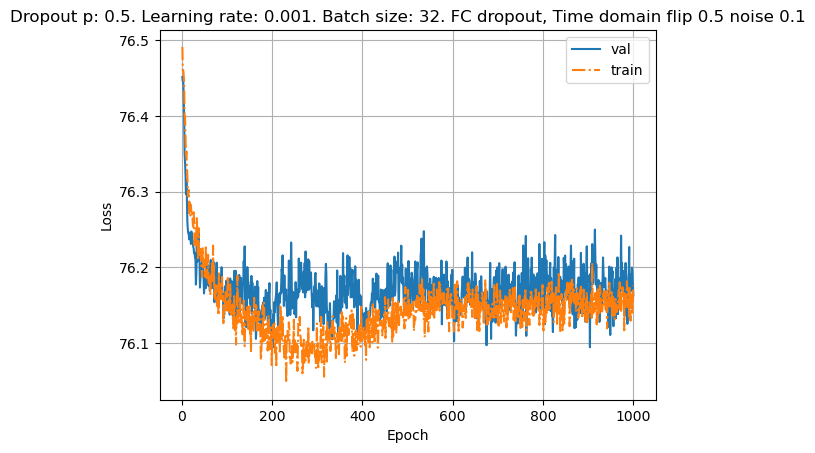

In [72]:
description = "FC dropout, Time domain flip 0.5 noise 0.1"

title = f"Dropout p: {dropout_p}. Learning rate: {lr}. Batch size: {batch_size}. {description}"

x = [i+1 for i in range(len(validation_data))]

plt.plot(x, validation_data, label ='val')
plt.plot(x, training_data, '-.', label ='train')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(title)
plt.grid()

plt.show()

 
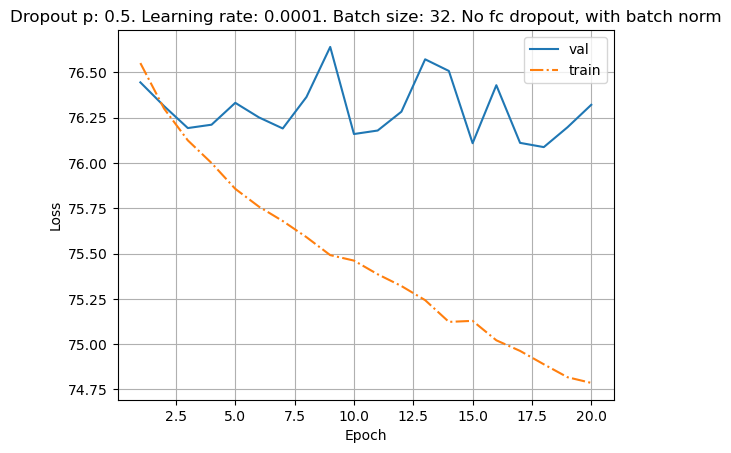  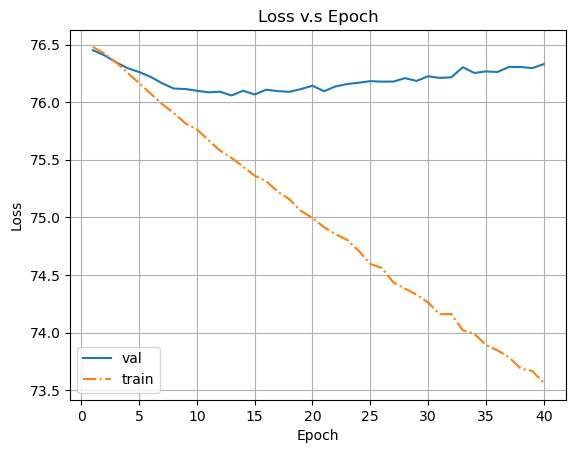 Dropout .25 no batch   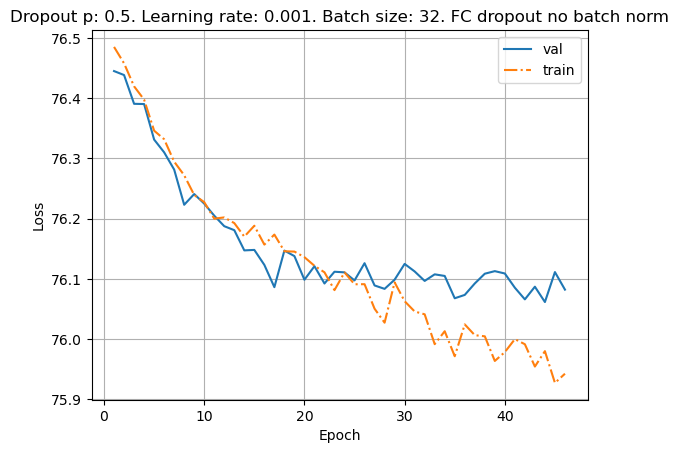   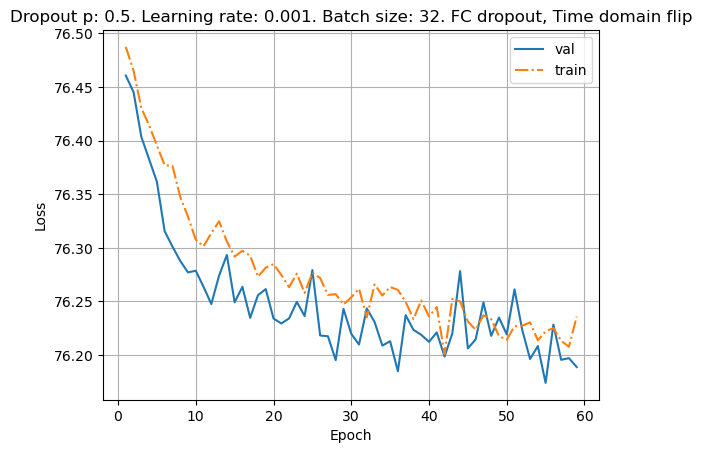
  
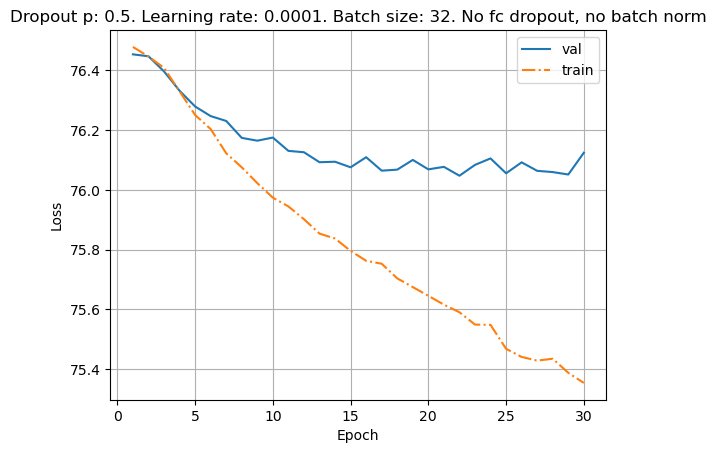  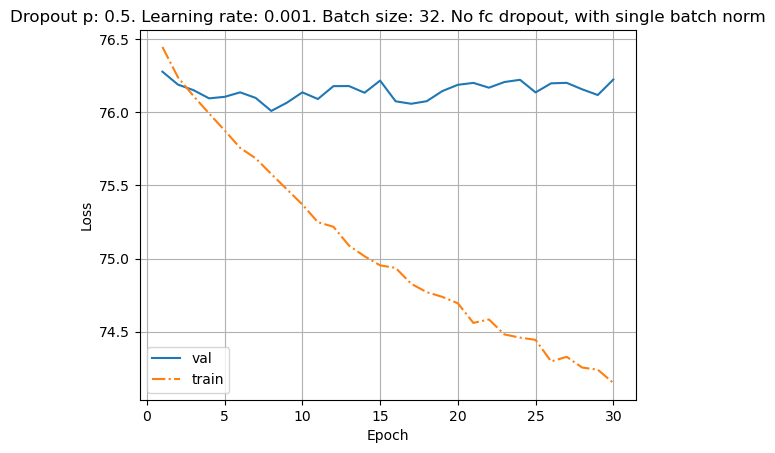   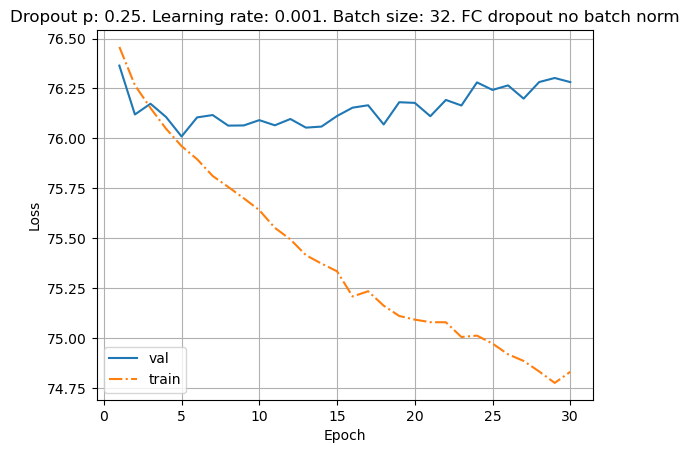  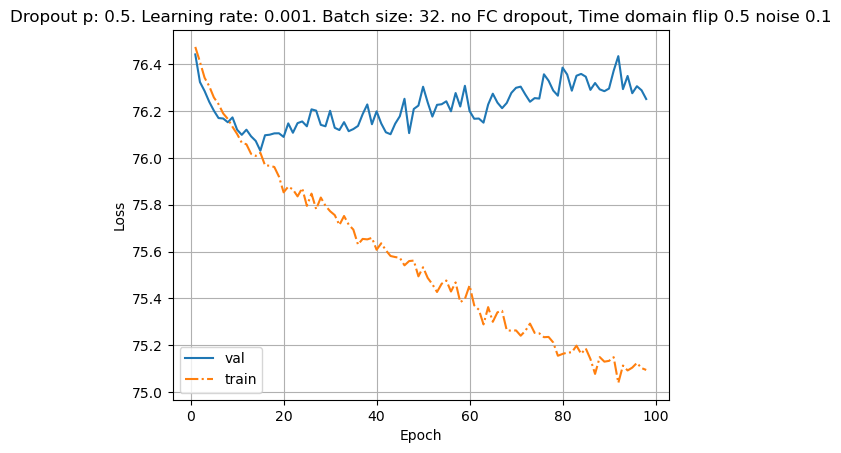  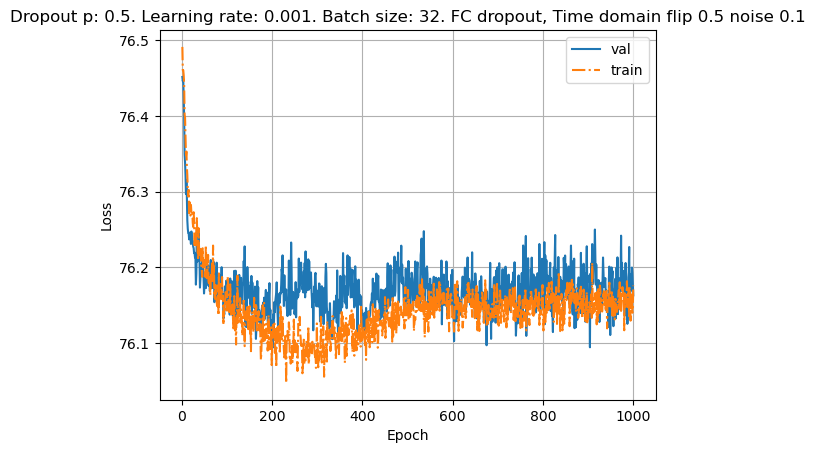